In [4]:
!pip install pyomo
!pip install pulp
!pip install matplotlib
!apt-get install -y -qq glpk-utils

Epsilon: 10
No se encontró una solución factible.

Epsilon: 20
Distancia Total: 137
Error Total: 18
Camino 1: 3 -> 5 -> 6
  Distancia Camino 1: 52
  Error Camino 1: 10
Camino 2: 3 -> 2 -> 7 -> 6
  Distancia Camino 2: 85
  Error Camino 2: 8


Epsilon: 30
Distancia Total: 96
Error Total: 28
Camino 1: 3 -> 7 -> 6
  Distancia Camino 1: 44
  Error Camino 1: 18
Camino 2: 3 -> 5 -> 6
  Distancia Camino 2: 52
  Error Camino 2: 10


Epsilon: 40
Distancia Total: 90
Error Total: 34
Camino 1: 3 -> 1 -> 6
  Distancia Camino 1: 46
  Error Camino 1: 16
Camino 2: 3 -> 7 -> 6
  Distancia Camino 2: 44
  Error Camino 2: 18


Epsilon: 50
Distancia Total: 75
Error Total: 49
Camino 1: 3 -> 7 -> 6
  Distancia Camino 1: 44
  Error Camino 1: 18
Camino 2: 3 -> 4 -> 6
  Distancia Camino 2: 31
  Error Camino 2: 31


Epsilon: 60
Distancia Total: 75
Error Total: 49
Camino 1: 3 -> 7 -> 6
  Distancia Camino 1: 44
  Error Camino 1: 18
Camino 2: 3 -> 2 -> 6
  Distancia Camino 2: 31
  Error Camino 2: 31


Epsilon: 70
Di

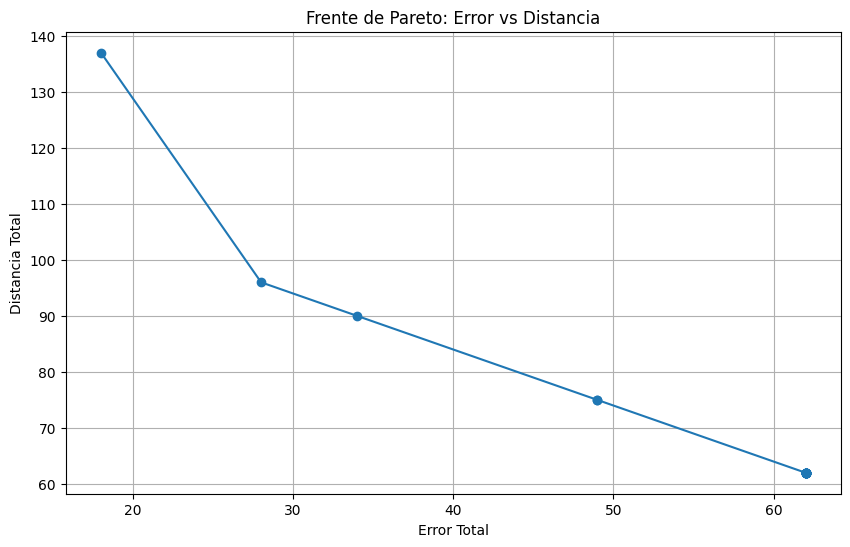

In [8]:
import pulp
import matplotlib.pyplot as plt

# Nodos
nodes = [1, 2, 3, 4, 5, 6, 7]

# Caminos
paths = [1, 2]

# Matriz de distancias D
D = {
    (1, 1): float('inf'), (1, 2): 21, (1, 3): 26, (1, 4): 19, (1, 5): 4,  (1, 6): 20, (1, 7): 14,
    (2, 1): 21, (2, 2): float('inf'), (2, 3): 29, (2, 4): 12, (2, 5): 25, (2, 6): 2,  (2, 7): 28,
    (3, 1): 26, (3, 2): 29, (3, 3): float('inf'), (3, 4): 17, (3, 5): 28, (3, 6): 16, (3, 7): 16,
    (4, 1): 19, (4, 2): 12, (4, 3): 17, (4, 4): float('inf'), (4, 5): 23, (4, 6): 14, (4, 7): 20,
    (5, 1): 4,  (5, 2): 25, (5, 3): 28, (5, 4): 23, (5, 5): float('inf'), (5, 6): 24, (5, 7): 28,
    (6, 1): 20, (6, 2): 2,  (6, 3): 16, (6, 4): 14, (6, 5): 24, (6, 6): float('inf'), (6, 7): 28,
    (7, 1): 14, (7, 2): 28, (7, 3): 16, (7, 4): 20, (7, 5): 28, (7, 6): 28, (7, 7): float('inf'),
}

# Matriz de error E
E = {
    (1, 1): float('inf'), (1, 2): 10, (1, 3): 5,  (1, 4): 12, (1, 5): 27, (1, 6): 11, (1, 7): 17,
    (2, 1): 10, (2, 2): float('inf'), (2, 3): 2,  (2, 4): 19, (2, 5): 6,  (2, 6): 29, (2, 7): 3,
    (3, 1): 5,  (3, 2): 2,  (3, 3): float('inf'), (3, 4): 14, (3, 5): 3,  (3, 6): float('inf'), (3, 7): 15,
    (4, 1): 12, (4, 2): 19, (4, 3): 14, (4, 4): float('inf'), (4, 5): 8,  (4, 6): 17, (4, 7): 11,
    (5, 1): 27, (5, 2): 6,  (5, 3): 3,  (5, 4): 8,  (5, 5): float('inf'), (5, 6): 7,  (5, 7): 17,
    (6, 1): 11, (6, 2): 29, (6, 3): float('inf'), (6, 4): 17, (6, 5): 7,  (6, 6): float('inf'), (6, 7): 3,
    (7, 1): 17, (7, 2): 3,  (7, 3): 15, (7, 4): 11, (7, 5): 17, (7, 6): 3,  (7, 7): float('inf'),
}

# Eliminar aristas con distancia infinita o error (aristas inexistentes)
edges = []
for i in nodes:
    for j in nodes:
        if D[(i, j)] != float('inf') and E[(i, j)] != float('inf') and i != j:
            edges.append((i, j))

prob = pulp.LpProblem("IoT_Network_Routing", pulp.LpMinimize)

# Variables de decisión
x = pulp.LpVariable.dicts("x", [(i, j, k) for (i, j) in edges for k in paths], cat='Binary')

# Función objetivo: Minimizar la distancia total
# Aunque las restricciones permitan loops, estos no sucederán ya que no son convenientes si lo que se quiere es minimizar distancias, son sobrantes que agregan distancias
prob += pulp.lpSum([D[(i, j)] * x[(i, j, k)] for (i, j) in edges for k in paths])

# Restricciones
# (1) Los caminos no se cruzan, para todo i,j en N: suma sobre k en C de x_{i,j,k} <= 1
for (i, j) in edges:
    prob += pulp.lpSum([x[(i, j, k)] for k in paths]) <= 1

# (2) Restricciones a la conservación del flujo
for k in paths:
    for i in nodes:
        if i != 6:
            prob += pulp.lpSum([x[(j, i, k)] for (j, i2) in edges if i2 == i]) <= pulp.lpSum([x[(i, j, k)] for (i1, j) in edges if i1 == i])

# (3) Cada nodo puede tener como máximo una conexión saliente en la ruta k
for k in paths:
    for i in nodes:
        prob += pulp.lpSum([x[(i, j, k)] for (i1, j) in edges if i1 == i]) <= 1

# (4) Cada nodo puede tener como máximo una conexión entrante en la ruta k
for k in paths:
    for i in nodes:
        prob += pulp.lpSum([x[(j, i, k)] for (j, i1) in edges if i1 == i]) <= 1

# (5) El nodo origen (nodo 3) debe tener exactamente una conexión saliente en el camino k
for k in paths:
    prob += pulp.lpSum([x[(3, j, k)] for (i, j) in edges if i == 3]) == 1

# (6) El nodo de destino (nodo 6) debe tener exactamente una conexión entrante en la ruta k
for k in paths:
    prob += pulp.lpSum([x[(j, 6, k)] for (j, i) in edges if i == 6]) == 1

# (7) El nodo origen no debe tener ninguna conexión entrante en la ruta k
for k in paths:
    prob += pulp.lpSum([x[(j, 3, k)] for (j, i) in edges if i == 3]) == 0

# (8) El nodo de destino no debe tener ninguna conexión saliente en la ruta k
for k in paths:
    prob += pulp.lpSum([x[(6, j, k)] for (i, j) in edges if i == 6]) == 0

# Método épsilon: El error total debe ser menor o igual a épsilon
# Definir una función para resolver el problema para un valor dado de épsilon
def solve_for_epsilon(epsilon):
    # Añadir la restricción épsilon
    prob.constraints["epsilon_constraint"] = pulp.LpConstraint(
        e=pulp.lpSum([E[(i, j)] * x[(i, j, k)] for (i, j) in edges for k in paths]),
        sense=pulp.LpConstraintLE,
        rhs=epsilon,
        name="epsilon_constraint"
    )
    prob.solve()
    # Comprobar si se ha encontrado una solución factible
    if pulp.LpStatus[prob.status] == 'Optimal':
        # Verificar que no hay ciclos y que no hay arcos seleccionados fuera de los caminos principales
        # Extraer las rutas
        paths_found = {}
        has_cycles = False
        for k in paths:
            path = []
            current_node = 3  # Empezar desde el origen
            visited_nodes = set()
            visited_nodes.add(current_node)
            while current_node != 6:
                found_next = False
                for (i, j) in edges:
                    if i == current_node and pulp.value(x[(i, j, k)]) == 1:
                        if j in visited_nodes:
                            # Se ha detectado un ciclo
                            has_cycles = True
                            break
                        path.append((i, j))
                        current_node = j
                        visited_nodes.add(current_node)
                        found_next = True
                        break
                if not found_next:
                    # No se encontró el siguiente nodo, camino incompleto
                    has_cycles = True
                    break
                if has_cycles:
                    break
            paths_found[k] = path
        # Comprobar si hay arcos seleccionados que no estén en los caminos principales
        extra_edges = []
        for (i, j) in edges:
            for k in paths:
                if pulp.value(x[(i, j, k)]) == 1 and (i, j) not in paths_found[k]:
                    extra_edges.append((i, j, k))
        if has_cycles or extra_edges:
            print(f"Epsilon: {epsilon}")
            print("La solución contiene ciclos o arcos adicionales fuera de los caminos principales.\n")
        else:
            # Calcular la distancia y el error por camino
            distance_per_path = {}
            error_per_path = {}
            for k in paths:
                distance = sum(D[(i, j)] for (i, j) in paths_found[k])
                error = sum(E[(i, j)] for (i, j) in paths_found[k])
                distance_per_path[k] = distance
                error_per_path[k] = error
            # Calcular la distancia y el error totales
            total_distance = sum(distance_per_path[k] for k in paths)
            total_error = sum(error_per_path[k] for k in paths)
            # Imprimir los resultados
            print(f"Epsilon: {epsilon}")
            print(f"Distancia Total: {total_distance}")
            print(f"Error Total: {total_error}")
            for k in paths:
                path_nodes = [3] + [j for (i, j) in paths_found[k]]
                print(f"Camino {k}: {' -> '.join(map(str, path_nodes))}")
                print(f"  Distancia Camino {k}: {distance_per_path[k]}")
                print(f"  Error Camino {k}: {error_per_path[k]}")
            print("\n")
    else:
        print(f"Epsilon: {epsilon}")
        print("No se encontró una solución factible.\n")

# Lista para almacenar los resultados
results = []

# Resolver para diferentes valores de épsilon
epsilon_values = range(10, 201, 10)  # Desde 10 hasta 200, incrementando de 10 en 10
for epsilon in epsilon_values:
    # Eliminar la restricción épsilon anterior
    if "epsilon_constraint" in prob.constraints:
        del prob.constraints["epsilon_constraint"]
    solve_for_epsilon(epsilon)
    # Guardar los resultados si se encontró una solución óptima
    if pulp.LpStatus[prob.status] == 'Optimal':
        total_distance = pulp.value(prob.objective)
        total_error = sum(E[(i, j)] * pulp.value(x[(i, j, k)]) for (i, j) in edges for k in paths)
        results.append((total_error, total_distance))

# Extraer los errores y distancias de los resultados
errors = [result[0] for result in results]
distances = [result[1] for result in results]

# Graficar el frente de Pareto
plt.figure(figsize=(10, 6))
plt.plot(errors, distances, marker='o')
plt.title('Frente de Pareto: Error vs Distancia')
plt.xlabel('Error Total')
plt.ylabel('Distancia Total')
plt.grid(True)
plt.show()
